<a href="https://colab.research.google.com/github/rafaelhamer/DSWP/blob/master/Kaggle_Labdata_Churn_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
pd.options.display.float_format = '{:.4f}'.format

def mostra_missing_value(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = 100*round((df.isnull().sum()/df.isnull().count()).sort_values(ascending = False), 2)
    missing_data = pd.concat([total, percent], axis = 1, keys=['Total', 'Percentual'])
    print(missing_data.head(10))

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
df_train = pd.read_csv('/gdrive/My Drive/Python/train.csv')
df_test  = pd.read_csv('/gdrive/My Drive/Python/test.csv')

alvo  = 'Churn'
chave = 'id'

In [4]:
df_train.head()

,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4030,Female,0,No,No,56.0000,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,NaN,45.0500,2560.1,0
1,6731,Male,0,Yes,Yes,nan,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.6500,332.65,0
2,6479,Female,0,Yes,No,60.0000,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.8000,6640.7,0
3,6861,Female,0,No,No,37.0000,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),101.9000,3545.35,1
4,3266,Male,0,Yes,Yes,29.0000,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.7500,1974.8,1


In [ ]:
df_train.dtypes

In [ ]:
# Facets
!pip install facets-overview==1.0.0
from google.colab import widgets
from IPython.core.display import display, HTML
import base64
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator

In [6]:
fsg = FeatureStatisticsGenerator()
dataframes = [{'table': df_train, 'name': 'trainData'}]

censusProto = fsg.ProtoFromDataFrames(dataframes)
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

In [ ]:
#@title Número de pontos para visualização no facets

SAMPLE_SIZE = df_train.shape[0] #@param
train_dive = df_train.sample(SAMPLE_SIZE).to_json(orient = 'records')

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr = train_dive)
display(HTML(html))

In [ ]:
mostra_missing_value(df_train)
mostra_missing_value(df_test)

In [ ]:
!pip install pyod

from sklearn.ensemble import IsolationForest

# Scaling variables
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF

#from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
#from pyod.models.lof import LOF
from scipy import stats

# remove warnings to keep notebook clean
import warnings
warnings.filterwarnings('ignore')

In [1]:
# Função para plotar o Boxplot
def boxplot_alvo(df, column):
    plt.rcdefaults()
    sns.catplot(x = alvo, y = column, kind = "box", data = df, height = 4, aspect = 1.5)
    
    # add data points to boxplot with stripplot
    sns.stripplot(x = alvo, y = column, data = df, alpha = 0.3, jitter = 0.3, color = 'k');
    plt.show()

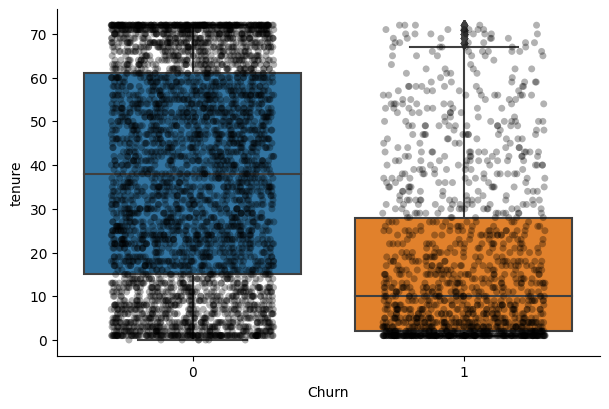

In [18]:
boxplot_alvo(df_train, 'tenure')

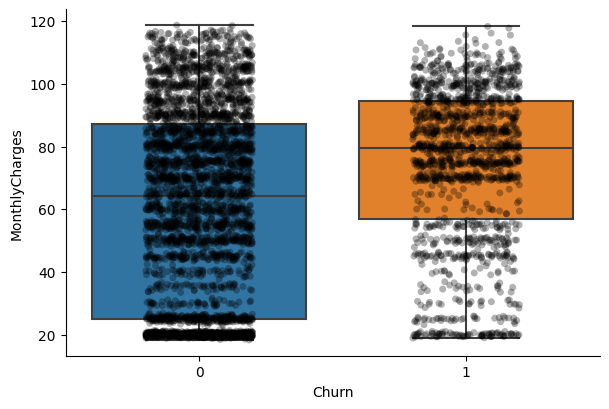

In [12]:
boxplot_alvo(df_train, 'MonthlyCharges')

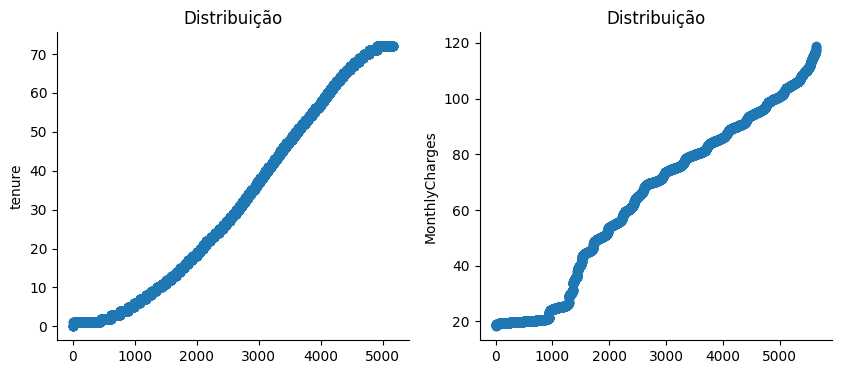

In [53]:
var_continuas = ['tenure','MonthlyCharges']
fig, ax = plt.subplots(1, len(var_continuas), figsize=(len(var_continuas)*5, 4))

for i in range(0, len(var_continuas)):
    ax[i].scatter(range(df_train.shape[0]), np.sort(df_train[var_continuas[i]].values)) # A intenção do gráfico é ordenar os valores do menor valor para o maior!
    ax[i].set_ylabel(var_continuas[i])
    ax[i].set_title('Distribuição')
    sns.despine()

plt.show()

___
## Kurtosis
> Kurtosis é uma medida estatística que define com que intensidade as caudas de uma distribuição diferem das caudas de uma distribuição Normal. Em outras palavras, a curtose identifica se as caudas de uma determinada distribuição contêm valores extremos.
> A Kurtosis de uma distribuição Normal padrão é igual a 3. Portanto, se Kurtosis-3 > 0, então isso é o que chamamos de excesso de Kurtosis.
> **Alta Kurtosis é um indicador de que os dados possuem caudas pesadas ou outliers**.

* **Dica muito importante**: Normalize os dados antes!

In [91]:
print(f"Kurtosis:")
for var in var_continuas:
    print(f"-> {var}: {df_train[var].kurt():.2f}")

print(f"\nSkewness:")
for var in var_continuas:
    print(f"-> {var}: {df_train[var].skew():.2f}")

Kurtosis:
-> tenure: -1.38
-> MonthlyCharges: -1.26

Skewness:
-> tenure: 0.25
-> MonthlyCharges: -0.22


___
## Skewness
> É o grau de distorção da distribuição, ou seja, mede a falta de simetria na distribuição de dados, diferenciando valores extremos em uma cauda versus na outra. Uma distribuição simétrica terá uma assimetria de 0.

![Skewness](https://github.com/MathMachado/Materials/blob/master/Skewness.png?raw=true)

Source: [Skew and Kurtosis: 2 Important Statistics terms you need to know in Data Science](https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa)

### Interpretando a Skewness (Rule of Thumb)
* Skewness < -1: Dados altamente negativa;
* -1 < Skewness < -0.5: Dados moderadamente negativa;
* -0.5 < Skewness < 0.5: Dados razoavelmente simétricos;
* 0.5 < Skewness < 1: Dados moderadamente positiva;
* Skewness > 1: Dados altamente positiva.

**Dica**: Normalize os dados antes!

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c051a4588>,
      dtype=object)

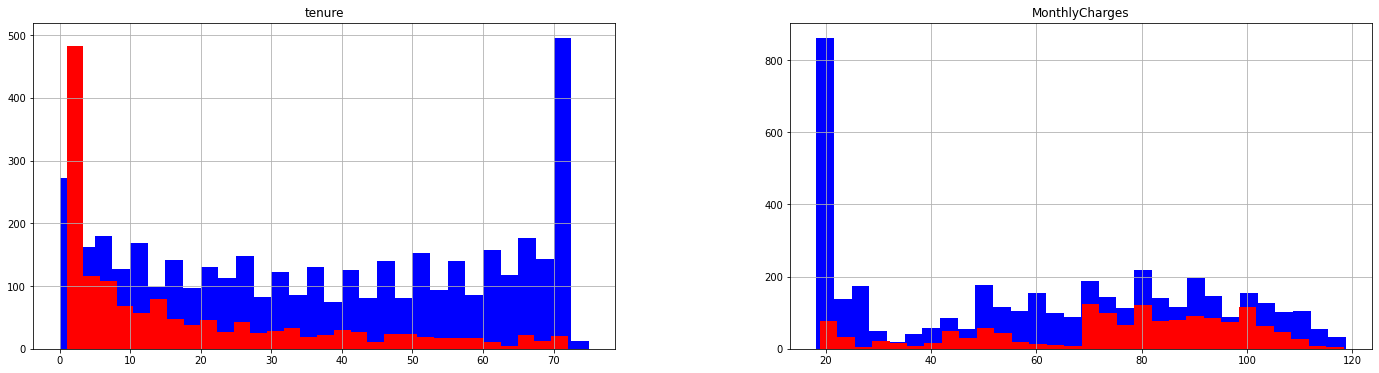

In [23]:
fig, ax = plt.subplots(1, len(var_continuas), figsize=(24, 6))
df_train[df_train[alvo] == 0][var_continuas].hist(color="blue", ax=ax, bins=30)
df_train[df_train[alvo] == 1][var_continuas].hist(color="red", ax=ax, bins=30)

In [5]:
def TrataMissingValues(df):
    df['TotalCharges'] = df['TotalCharges'].str.replace(' ','0.0').astype(np.float64)
    df['tenure'] = df['tenure'].fillna(round(df['TotalCharges'].astype(np.float64) / df['MonthlyCharges'])).astype('int64')

    df['Dependents'].fillna('MISS', inplace=True)
    df.loc[(df['Partner'] == 'No') & (df['Dependents'] == 'MISS'), 'Dependents'] = "No"

    df['PaymentMethod'].fillna('MISS', inplace=True)

    return df

In [39]:
TrataMissingValues(df_train)
TrataMissingValues(df_test)
df_train.head()

,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4030,Female,0,No,No,56,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,MISS,45.0500,2560.1000,0
1,6731,Male,0,Yes,Yes,17,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.6500,332.6500,0
2,6479,Female,0,Yes,No,60,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.8000,6640.7000,0
3,6861,Female,0,No,No,37,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),101.9000,3545.3500,1
4,3266,Male,0,Yes,Yes,29,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.7500,1974.8000,1


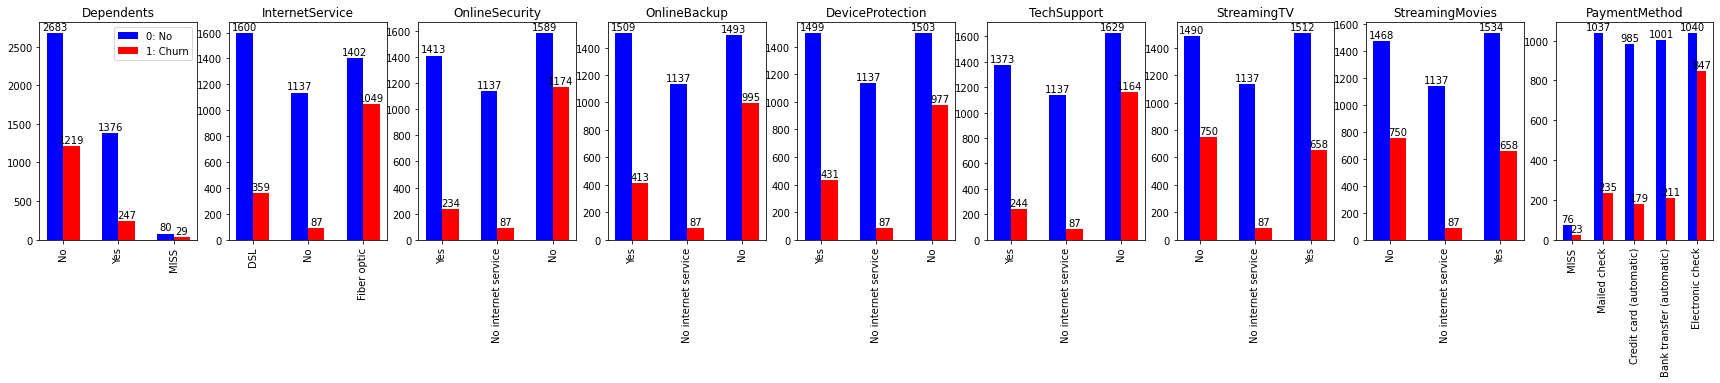

In [20]:
fig, ax = plt.subplots(1, len(var_categoricas_mult), figsize=(30, 4))

for i in range(0,len(var_categoricas_mult)):
    num_results = df_train[var_categoricas_mult[i]].nunique()
    valores0 = np.arange(num_results)
    valores1 = np.arange(num_results)
    x_label  = np.arange(num_results)

    for x in range(0,num_results):
        valores0[x] = len(df_train.loc[df_train[var_categoricas_mult[i]] == df_train[var_categoricas_mult[i]].unique()[x]].loc[df_train[alvo] == 0])
        valores1[x] = len(df_train.loc[df_train[var_categoricas_mult[i]] == df_train[var_categoricas_mult[i]].unique()[x]].loc[df_train[alvo] == 1])

    rects0 = ax[i].bar(x_label-.15, valores0, align='center', width=.3, color='blue', label='0: No')
    rects1 = ax[i].bar(x_label+.15, valores1, align='center', width=.3, color='red', label='1: Churn')
    
    def autolabel(rects):     
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax[i].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 1 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    autolabel(rects0)
    autolabel(rects1)
    
    ax[i].set_title(var_categoricas_mult[i])
    ax[i].set_xticks(x_label)
    ax[i].set_xticklabels(df_train[var_categoricas_mult[i]].unique(), rotation=90)
    #ax[i].set_ylim(0,len(df_train))

ax[0].legend(loc='upper right')
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (6, 6)
sns.heatmap(df_train.drop([chave,alvo],axis=1).corr(), annot=True, cmap='Blues')

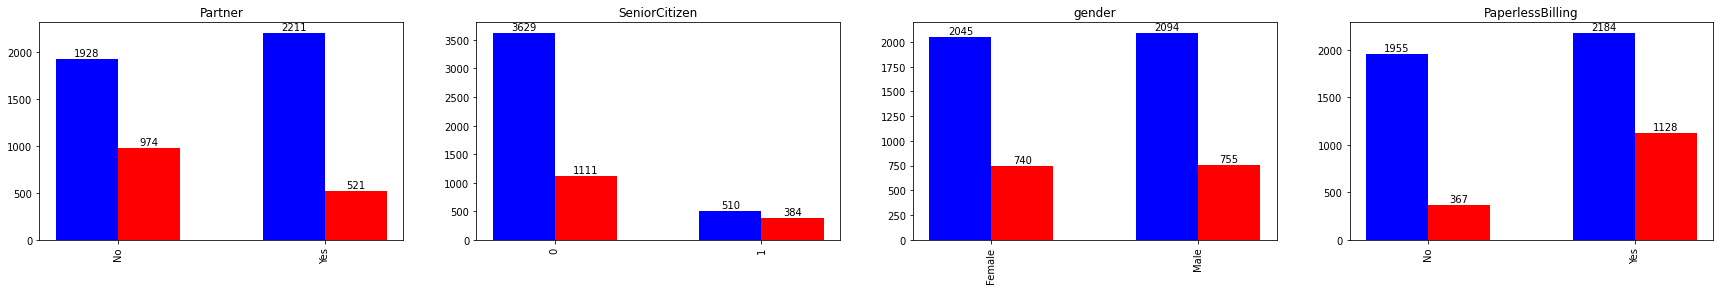

In [22]:
fig, ax = plt.subplots(1, len(var_categoricas_bina), figsize=(30, 4))

for i in range(0,len(var_categoricas_bina)):
    num_results = df_train[var_categoricas_bina[i]].nunique()
    valores0 = np.arange(num_results)
    valores1 = np.arange(num_results)
    x_label  = np.arange(num_results)

    for x in range(0,num_results):
        valores0[x] = len(df_train.loc[df_train[var_categoricas_bina[i]] == df_train[var_categoricas_bina[i]].unique()[x]].loc[df_train[alvo] == 0])
        valores1[x] = len(df_train.loc[df_train[var_categoricas_bina[i]] == df_train[var_categoricas_bina[i]].unique()[x]].loc[df_train[alvo] == 1])

    rects0 = ax[i].bar(x_label-.15, valores0, align='center', width=.3, color='blue', label='0: No')
    rects1 = ax[i].bar(x_label+.15, valores1, align='center', width=.3, color='red', label='1: Churn')
    
    def autolabel(rects):     
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax[i].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 1 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    autolabel(rects0)
    autolabel(rects1)
    
    ax[i].set_title(var_categoricas_bina[i])
    ax[i].set_xticks(x_label)
    ax[i].set_xticklabels(df_train[var_categoricas_bina[i]].unique(), rotation=90)
    #ax[i].legend()
    #ax[i].set_ylim(0,len(df_train))

plt.show()

In [ ]:
for i in range(0,76):
    print(i, ':', df_train[(df_train[alvo] == 1) & (df_train['tenure'] == i)][alvo].sum())

In [ ]:
for i in range(19,119):
    print(i, ':', df_train[(df_train[alvo] == 1) & (round(df_train['MonthlyCharges']) == i)][alvo].sum())

___
## **Isolation Forest**

OUTLIERS:  2 INLIERS:  180


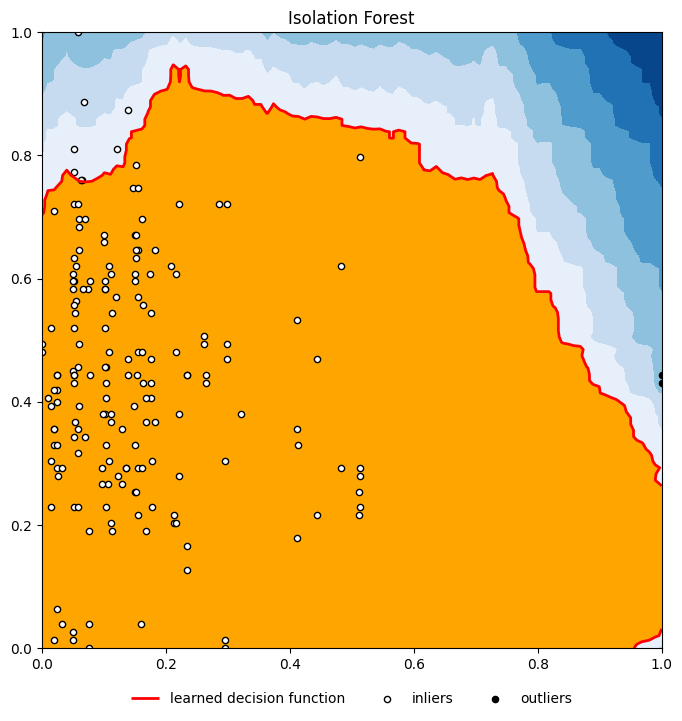

In [ ]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = IForest(contamination = outliers_fraction,random_state = 0)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize = (8, 8))
# copy of dataframe
df1 = df_titanic_ss
df1['outlier'] = y_pred.tolist()
    
# fare - inlier feature 1,  age - inlier feature 2
inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1,1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1,1)
    
# fare - outlier feature 1, age - outlier feature 2
outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ', n_outliers,'INLIERS: ', n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels= [threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels= [threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_fare, outliers_age, c='black',s=20, edgecolor='k')
       
plt.axis('tight')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers', 'outliers'],
           prop=matplotlib.font_manager.FontProperties(size = 10), loc='upper center', frameon= False, bbox_to_anchor = (0.5, -0.05),
          fancybox = True, shadow = True, ncol=5)
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Isolation Forest')
plt.show();

In [ ]:
# Zoom em alguns outliers...
df1.loc[df1['outlier'] == 1].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,outlier
679,1,1,male,0.444,0,1,1.000,C,First,man,True,B,Cherbourg,yes,False,1
737,1,1,male,0.431,0,0,1.000,C,First,man,True,B,Cherbourg,yes,True,1


In [2]:
def TratamentoFinal(df):

    df['MultaQuebraContrato'] = 0
    df.loc[(df['Contract'] == 'One year') & (df['tenure'] < 12), 'MultaQuebraContrato'] = 1
    df.loc[(df['Contract'] == 'Two year') & (df['tenure'] < 24), 'MultaQuebraContrato'] = 1
    #df.loc[df['Contract'] != 'Month-to-month', 'Contract'] = 'Yearly'
    #df.drop('Contract', axis=1, inplace=True)

    df['tenure_cat'] = pd.cut(df['tenure'], bins = [0, 1, 2, 11, 50, 69, 72, 130])
    df.loc[(df['tenure'] >=  2) & (df['tenure'] <= 11), 'tenure'] = 2
    df.loc[(df['tenure'] >= 12) & (df['tenure'] <= 50), 'tenure'] = 3
    df.loc[(df['tenure'] >= 51) & (df['tenure'] <= 69), 'tenure'] = 4
    df.loc[(df['tenure'] >= 70) & (df['tenure'] <= 72), 'tenure'] = 5
    df.loc[(df['tenure'] >= 73), 'tenure'] = 6
    df['MonthlyCharges'] = round((df['MonthlyCharges']-9) / 12).astype('int64')
    #df['MonthlyCharges'] = df['MonthlyCharges'].astype('int64')
    #df.loc[(df['MonthlyCharges'] >=  0) & (df['MonthlyCharges'] < 20), 'MonthlyCharges'] = 1
    #df.loc[(df['MonthlyCharges'] >= 20) & (df['MonthlyCharges'] < 44), 'MonthlyCharges'] = 2
    #df.loc[(df['MonthlyCharges'] >= 44) & (df['MonthlyCharges'] < 88), 'MonthlyCharges'] = 3
    #df.loc[(df['MonthlyCharges'] >= 88) & (df['MonthlyCharges'] < 104), 'MonthlyCharges'] = 4
    #df.loc[(df['MonthlyCharges'] >= 104), 'MonthlyCharges'] = 5

    df.loc[(df['PaymentMethod'] != 'Electronic check'), 'PaymentMethod'] = 'No Electronic check'

    df['MultipleLines']    = df['MultipleLines'].str.replace('No phone service','No')
    df['OnlineSecurity']   = df['OnlineSecurity'].str.replace('No internet service','No')
    df['OnlineBackup']     = df['OnlineBackup'].str.replace('No internet service','No')
    df['DeviceProtection'] = df['DeviceProtection'].str.replace('No internet service','No')
    df['TechSupport']      = df['TechSupport'].str.replace('No internet service','No')
    df['StreamingTV']      = df['StreamingTV'].str.replace('No internet service','No')
    df['StreamingMovies']  = df['StreamingMovies'].str.replace('No internet service','No')

    for var in var_eliminar:
        df.drop(var, axis=1, inplace=True)
    '''
    df.drop('gender', axis=1, inplace=True)
    df.drop('PhoneService', axis=1, inplace=True)
    df.drop('MultipleLines', axis=1, inplace=True)
    df.drop('Dependents_MISS', axis=1, inplace=True)
    df.drop('Dependents_No', axis=1, inplace=True)
    df.drop('TotalCharges', axis=1, inplace=True)
    df.drop('PaymentMethod_MISS', axis=1, inplace=True)
    df.drop('InternetService_No', axis=1, inplace=True)

    df['ServicosReclamacao'] = df['OnlineSecurity_No'] + df['OnlineBackup_No'] + df['DeviceProtection_No'] + df['TechSupport_No']
    df.drop('OnlineSecurity_Yes', axis=1, inplace=True)
    df.drop('OnlineSecurity_No', axis=1, inplace=True)
    df.drop('OnlineSecurity_No internet service', axis=1, inplace=True)
    df.drop('OnlineBackup_Yes', axis=1, inplace=True)
    df.drop('OnlineBackup_No', axis=1, inplace=True)
    df.drop('OnlineBackup_No internet service', axis=1, inplace=True)
    df.drop('DeviceProtection_Yes', axis=1, inplace=True)
    df.drop('DeviceProtection_No', axis=1, inplace=True)
    df.drop('DeviceProtection_No internet service', axis=1, inplace=True)
    df.drop('TechSupport_Yes', axis=1, inplace=True)
    df.drop('TechSupport_No', axis=1, inplace=True)
    df.drop('TechSupport_No internet service', axis=1, inplace=True)

    df['Streaming'] = df['StreamingTV_Yes'] | df['StreamingMovies_Yes']
    df.drop('StreamingTV_Yes', axis=1, inplace=True)
    df.drop('StreamingTV_No', axis=1, inplace=True)
    df.drop('StreamingTV_No internet service', axis=1, inplace=True)
    df.drop('StreamingMovies_Yes', axis=1, inplace=True)
    df.drop('StreamingMovies_No', axis=1, inplace=True)
    df.drop('StreamingMovies_No internet service', axis=1, inplace=True)
    '''
    return df

In [43]:
var_eliminar  = ['TotalCharges']
var_continuas = ['tenure','MonthlyCharges']
var_categoricas      = list(set(df_train) - set(var_continuas) - set(var_eliminar) - set([chave]) - set([alvo]))
var_categoricas_mult = ['Dependents','InternetService','PaymentMethod','Contract']
var_categoricas_bina = list(set(df_train) - set(var_categoricas_mult) - set(var_continuas) - set(var_eliminar) - set([chave]) - set([alvo]))

print('Variáveis Categóricas Binárias:', var_categoricas_bina)

Variáveis Categóricas Binárias: ['OnlineSecurity', 'SeniorCitizen', 'PhoneService', 'StreamingMovies', 'DeviceProtection', 'PaperlessBilling', 'StreamingTV', 'gender', 'MultipleLines', 'TechSupport', 'Partner', 'OnlineBackup']


In [ ]:
df_train = pd.read_csv('/gdrive/My Drive/Python/train.csv')
df_test  = pd.read_csv('/gdrive/My Drive/Python/test.csv')
TrataMissingValues(df_train)
TrataMissingValues(df_test)
TratamentoFinal(df_train)
TratamentoFinal(df_test)
'''
for var_cat in var_categoricas_mult:
    df_train = pd.get_dummies(df_train, columns=[var_cat])
    df_test  = pd.get_dummies(df_test, columns=[var_cat])
'''
le = LabelEncoder()
for var_cat in var_categoricas_bina:
    df_train[var_cat] = le.fit_transform(df_train[var_cat])
    df_test[var_cat] = le.fit_transform(df_test[var_cat])

df_train.head()

In [51]:
df_test.head()

,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,MultaQuebraContrato
0,5027,1,0,1,Yes,3,1,0,No,0,0,0,0,0,0,One year,1,No Electronic check,1,0
1,1733,1,1,1,Yes,4,1,1,Fiber optic,0,1,0,0,1,1,One year,0,No Electronic check,8,0
2,5384,1,0,0,No,3,1,1,Fiber optic,0,0,0,0,0,1,Month-to-month,1,Electronic check,6,0
3,6554,0,0,1,Yes,4,0,0,DSL,0,1,1,1,1,1,Two year,1,No Electronic check,4,0
4,364,0,0,0,No,3,1,0,No,0,0,0,0,0,0,Two year,1,No Electronic check,1,0


In [52]:
df_train.describe()

,id,gender,SeniorCitizen,Partner,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,Churn,MultaQuebraContrato
count,5634.0000,5634.0000,5634.0000,5634.0000,5634.0000,5634.0000,5634.0000,5634.0000,5634.0000,5634.0000,5634.0000,5634.0000,5634.0000,5634.0000,5634.0000,5634.0000,5634.0000
mean,3530.3135,0.5057,0.1587,0.4849,3.0110,0.9020,0.4242,0.2923,0.3411,0.3426,0.2870,0.3852,0.3891,0.5879,4.6253,0.2654,0.0341
std,2036.1951,0.5000,0.3654,0.4998,1.0730,0.2973,0.4943,0.4549,0.4741,0.4746,0.4524,0.4867,0.4876,0.4923,2.5232,0.4416,0.1814
min,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
25%,1775.2500,0.0000,0.0000,0.0000,2.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000
50%,3525.5000,1.0000,0.0000,0.0000,3.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,5.0000,0.0000,0.0000
75%,5303.7500,1.0000,0.0000,1.0000,4.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,7.0000,1.0000,0.0000
max,7043.0000,1.0000,1.0000,1.0000,6.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,9.0000,1.0000,1.0000


In [54]:
df_train.to_csv('/gdrive/My Drive/Python/treino_limpo.csv', index=False)
df_test.to_csv('/gdrive/My Drive/Python/teste_limpo.csv', index=False)